## Image Captioning

- Input: image.
- Output: A sequence of words in a natural language, which hopefully describes the contents of the input Image.

## Libraries

In [66]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.transforms as transforms
import torchvision.models as models

#from utils import *
from build_vocab import build_vocab
from data_loader import get_loader

# setup
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


### Helper functions

In [67]:
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained)


def load_image(image_path, transform=None):
    "Load an image and perform given transformations."
    image = Image.open(image_path)    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image

## Data

- [Microsoft COCO Dataset](http://cocodataset.org/#captions-2015)
- More than 80k training images and 40k validation images.
- At leat 5 captions for every image.

### Load Images and Captions Data

In [68]:
def load_json(filename='data/fa_images_captions_train.json'):
    with open(filename, 'r') as f:
        annotations = json.load(f)
    return annotations

dataset = load_json('/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/annotations/captions_val2014.json')

In [69]:
print(dataset.keys())

dict_keys(['info', 'images', 'licenses', 'annotations'])


In [9]:
print(dataset['images'][0])

{'license': 3, 'file_name': 'COCO_val2014_000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


In [10]:
print(dataset['annotations'][0])

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}


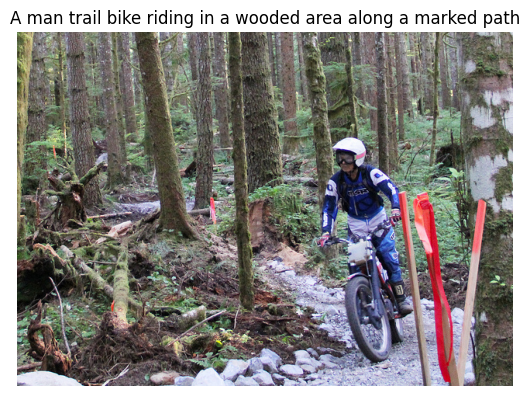

In [70]:

#show_random_image_with_caption(dataset)
def show_image(image_file, caption):
    img = plt.imread(image_file)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, size='large')

# pick a random image and obtain the corresponding caption and filename
N = len(dataset['annotations'])
idx = np.random.choice(range(N))

item = dataset['annotations'][idx]
caption = item['caption']

img_id = item['image_id']

# Find the image file name corresponding to the img_id
filename = None
for image in dataset['images']:
    if image['id'] == img_id:
        filename = image['file_name']
        break

if filename is None:
    print(f"Image with id {img_id} not found.")
else:
    image_file = os.path.join('/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/val2014/', filename)
    show_image(image_file, caption)

### Building vocabulary

In [71]:
DATA_DIR = 'data'
captions_filename = f'{DATA_DIR}/captions.txt'

N = len(dataset['annotations'])
for id in range(N):
    item = dataset['annotations'][id]
    caption = item['caption']
    with open(captions_filename, 'a') as file:
    # Append content to the file
        file.write(caption.lower() + '\n')

In [72]:
DATA_DIR = 'data'
#captions_filename = f'{DATA_DIR}/fa_captions.txt'
vocab_filename = f'{DATA_DIR}/vocab.pkl'

if os.path.exists(vocab_filename):
    vocab = pickle.load(open(vocab_filename, 'rb'))
else:
    vocab = build_vocab(captions_filename, min_count=0)
    pickle.dump(vocab, open(vocab_filename, 'wb'))

Vocab:   0%|          | 0/203451 [00:00<?, ?it/s]

In [73]:
print(len(vocab))

17496


In [74]:
for i in range(100):
    print("%s --> %d" %(vocab.idx2word[i], i))

<PAD> --> 0
<BOS> --> 1
<EOS> --> 2
<UNK> --> 3
a --> 4
. --> 5
on --> 6
of --> 7
the --> 8
in --> 9
with --> 10
and --> 11
is --> 12
man --> 13
to --> 14
sitting --> 15
an --> 16
two --> 17
, --> 18
at --> 19
standing --> 20
people --> 21
are --> 22
next --> 23
white --> 24
woman --> 25
street --> 26
table --> 27
that --> 28
holding --> 29
it --> 30
large --> 31
person --> 32
some --> 33
top --> 34
down --> 35
up --> 36
group --> 37
field --> 38
tennis --> 39
front --> 40
black --> 41
small --> 42
train --> 43
near --> 44
his --> 45
dog --> 46
cat --> 47
plate --> 48
riding --> 49
room --> 50
red --> 51
young --> 52
by --> 53
water --> 54
has --> 55
playing --> 56
sign --> 57
bathroom --> 58
baseball --> 59
walking --> 60
while --> 61
blue --> 62
building --> 63
kitchen --> 64
side --> 65
there --> 66
food --> 67
green --> 68
bus --> 69
pizza --> 70
grass --> 71
parked --> 72
bed --> 73
other --> 74
clock --> 75
looking --> 76
beach --> 77
snow --> 78
toilet --> 79
for --> 80
ball -->

### Data loader

In [86]:
DATASET_DIR = '/mnt/home/mnikzad/ML_Practice/Image_Captioning/cocoapi/'
images_dir = f'{DATASET_DIR}/val2014'
captions_json = f'{DATASET_DIR}/annotations/captions_val2014.json'
image_size = 256
crop_size  = 224
batch_size = 16


transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [87]:
data_loader = get_loader(images_dir, captions_json, vocab, 
                         transform, batch_size, 
                         shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


In [29]:
# Assuming data_loader is your PyTorch DataLoader
imgs, caps, lengths = next(iter(data_loader))

# Extracting the first caption and removing special tokens
first_caption_ids = caps[0][1:-1]

# Print word IDs
print("Word IDs:", " ".join([str(id.item()) for id in first_caption_ids]))

# Print corresponding words, handling missing indices
print("Words:", " ".join([vocab.idx2word.get(id.item(), '<unk>') for id in first_caption_ids]))



Word IDs: 3 372 4 405 7 423 135 9 1747 1305 15 23 14 4 372 4 405 7 423 135 10 2417 6 4 307 122 23 14 4 427 5
Words: <UNK> half a slice of bread covered in peanut butter sitting next to a half a slice of bread covered with jelly on a cutting board next to a knife .


In [12]:
imgs.size()

torch.Size([16, 3, 224, 224])

In [13]:
print(caps.size())

torch.Size([16, 24])


## Model

<img src="imgs/enc-dec-arch.png" width="90%"/>

In [114]:
def to_var(x, requires_grad=False):
    if torch.cuda.is_available():
        #print(torch.cuda.is_available())
        x = x.cuda()
    return x.clone().detach().requires_grad_(requires_grad)

### Encoder (CNN)

In [115]:
class EncoderCNN(nn.Module):
    def __init__(self, model_name, embed_size):
        super(EncoderCNN, self).__init__()
        
        # Load pretrained CNN and remove the last fully connected layer
        cnn = self.load_cnn_model(model_name)
        modules = list(cnn.children())[:-1]  # remove the last layer
        
        self.cnn = nn.Sequential(*modules)
        self.linear = nn.Linear(cnn.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
                
    def init_weights(self):
        self.linear.weight.data.normal_(0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, x):
        x = self.cnn(x)  # extract features from input image
        x = x.view(x.size(0), -1)  # flatten the output
        x = self.linear(x)
        x = self.bn(x)
        return x
    
    def fine_tune(self, requires_grad=True):
        for param in self.cnn.parameters():
            param.requires_grad = requires_grad

    def load_cnn_model(self, model_name):
        # Example function to load a CNN model from torchvision
        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
        elif model_name == 'resnet101':
            model = models.resnet101(pretrained=True)
        else:
            raise ValueError(f"Model {model_name} is not supported.")
        
        return model

### Decoder (LSTM)

In [116]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights=False, pretrained_embeddings=None, freeze_embeddings=False):
        """
        Initializes the DecoderLSTM class.

        Args:
            vocab_size (int): Size of the vocabulary.
            embed_size (int): Dimension of the word embeddings.
            hidden_size (int): Number of features in the hidden state of the LSTM.
            num_layers (int): Number of recurrent layers in the LSTM.
            dropout (float): Dropout probability for regularization.
            tie_weights (bool): Whether to tie the weights of the embedding and the final linear layer.
            pretrained_embeddings (Tensor, optional): Pre-trained embedding weights. Defaults to None.
            freeze_embeddings (bool, optional): Whether to freeze the embedding weights. Defaults to False.
        """
        super(DecoderLSTM, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        
        if tie_weights:
            # Share weights between embedding and classification layer
            if pretrained_embeddings is not None:
                assert embed_size == hidden_size, "Embedding size must match hidden size when tying weights"
            self.fc.weight = self.embedding.weight
            
        self.init_weights(pretrained_embeddings)
        
    def init_weights(self, pretrained_embeddings):
        """Initializes the weights of the model."""
        if pretrained_embeddings is None:
            self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        """
        Forward pass for the decoder.

        Args:
            features (Tensor): Image features from the encoder.
            captions (Tensor): Ground truth captions for training.
            lengths (list of int): Lengths of the captions.

        Returns:
            Tensor: The output of the decoder.
        """
        embeddings = self.embedding(captions)
        embeddings = torch.cat([features.unsqueeze(1), embeddings], dim=1)
        embeddings = self.dropout(embeddings)
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed)
       # lstm_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        #lstm_output = self.dropout(lstm_output)
        lstm_output = self.dropout(packed_output.data)

        outputs = self.fc(lstm_output)
        return outputs
    
    
        
    def sample(self, features, states=None, max_length=20):
        """
        Samples captions for given image features using greedy search.

        Args:
            features (Tensor): Image features from the encoder.
            states (tuple of Tensor, optional): Initial hidden states of the LSTM. Defaults to None.
            max_length (int, optional): Maximum length of the generated captions. Defaults to 20.

        Returns:
            list: List of sampled word IDs.
        """
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(max_length):
            hiddens, states = self.lstm(inputs, states)  # (batch_size, 1, hidden_size)
            outputs = self.fc(hiddens.squeeze(1))        # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]                # (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embedding(predicted)           # (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                 # (batch_size, 1, embed_size)
        
        sampled_ids = torch.stack(sampled_ids, 1)        # (batch_size, max_length)
        return sampled_ids


In [117]:

def load_glove_embeddings(glove_file, vocab):
    """
    Load GloVe embeddings from a file and create an embedding matrix for a given vocabulary.

    Args:
        glove_file (str): Path to the GloVe file.
        vocab (dict): Vocabulary dictionary with word to index mappings.

    Returns:
        torch.Tensor: Embedding matrix with GloVe embeddings.
    """
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_dim = len(next(iter(embeddings_index.values())))
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, i in vocab.word2idx.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return torch.tensor(embedding_matrix, dtype=torch.float32)

# Path to your GloVe file
glove_file = 'glove.6B.300d.txt'
vocab_filename = 'data/vocab.pkl'

if os.path.exists(vocab_filename):
    with open(vocab_filename, 'rb') as f:
        vocab = pickle.load(f)
else:
    raise FileNotFoundError("Vocabulary file not found.")

pretrained_embeddings = load_glove_embeddings(glove_file, vocab)

### Encoder-Decoder

In [118]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, cnn_name, vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights, pretrained_embeddings=None):
        super(EncoderDecoder, self).__init__()
        
        if tie_weights:
            embed_size = hidden_size
            
        self.encoder = EncoderCNN(cnn_name, embed_size)
        self.decoder = DecoderLSTM(vocab_size, embed_size, hidden_size, num_layers, dropout, tie_weights, pretrained_embeddings)
        
        self.save_path = f'{cnn_name}-{embed_size}-{hidden_size}-{num_layers}'
        os.makedirs(self.save_path, exist_ok=True)
    
    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs
    
    def save(self, epoch, loss):
        save_filename = f'{self.save_path}/{epoch}-{loss:.2f}.pth'
        torch.save({
            'encoder': self.encoder.state_dict(),
            'decoder': self.decoder.state_dict()
        }, save_filename)
        print(f'Model saved to {save_filename}')
    
    def load(self, epoch):
        try:
            model_path = glob(f'{self.save_path}/{epoch}-*.pth')[-1]
            state_dict = torch.load(model_path)
            self.encoder.load_state_dict(state_dict['encoder'])
            self.decoder.load_state_dict(state_dict['decoder'])
            print(f'Model loaded from {model_path}')
        except IndexError:
            print(f'Error: Model for epoch {epoch} not found!')
        except Exception as e:
            print(f'Error loading model: {e}')

### Parameters

In [119]:
# training hyper-parameters
start_epoch = 0
num_epochs  = 2
learning_rate = 0.001

## Training

In [120]:
def train_epoch(model, train_dl, criterion, optimizer, scheduler, epoch, last_epoch):
    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    
    total_steps = len(train_dl)
    epoch_loss = 0.0
    
    for i, (images, captions, lengths) in enumerate(train_dl):
        images, captions = to_var(images), to_var(captions)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        
        # forward step
        outputs = model(images, captions, lengths)
        #print("Shape of outputs:", outputs.shape)
        #print("Shape of targets:", targets.shape)
        #print("target = ", targets)
        #print("Words:", " ".join([vocab.idx2word.get(id.item(), '<unk>') for id in targets]))

        loss = criterion(outputs, targets)
        epoch_loss = (epoch_loss * i + loss.item()) / (i + 1)
        
        # backward step
        model.encoder.zero_grad()
        model.decoder.zero_grad()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)
        optimizer.step()
        
        # report log info
        sys.stdout.flush()
        sys.stdout.write('\rEpoch [%2d/%2d], Step [%3d/%3d], Loss = %.4f, Perplexity = %.4f    '
                         % (epoch+1, last_epoch, i+1, total_steps, epoch_loss, np.exp(epoch_loss)))
    print()

    return epoch_loss


def train(model, train_dl, criterion, optimizer, scheduler, start_epoch=0, num_epochs=10):
    last_epoch = start_epoch + num_epochs
        
    for epoch in range(start_epoch, last_epoch):                
        # train step
        trn_loss = train_epoch(model, data_loader, criterion, optimizer, scheduler, epoch, last_epoch)
        
        # save model
        model.save(epoch, trn_loss)

### Encoder-Decoder

In [121]:
model = EncoderDecoder(
    cnn_name='resnet50',
    vocab_size=len(vocab),
    embed_size=300,  # Assuming 300-dimensional GloVe vectors
    hidden_size=300,
    num_layers=2,
    dropout=0.5,
    tie_weights=True,
    pretrained_embeddings=pretrained_embeddings
)
if use_gpu:
    model = model.cuda()
    #print(use_gpu)

### Loss and optimizer

In [122]:
# loss function
criterion = nn.CrossEntropyLoss()
if use_gpu:
    criterion = criterion.cuda()
    
# list of parameters which will be updated
params = list(model.decoder.parameters())
params += list(model.encoder.linear.parameters()) 
params += list(model.encoder.bn.parameters())

# optimizer
optimizer = torch.optim.RMSprop(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)



### Training

In [123]:
train(model, data_loader, criterion, optimizer, scheduler, start_epoch, num_epochs)

/tmp/ipykernel_1762722/1247313671.py:28: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.decoder.parameters(), 5.0)


Epoch [ 1/ 2], Step [2245/12666], Loss = 3.7694, Perplexity = 43.3533      

## Sampling: generate captions

In [43]:
from PIL import Image

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

In [54]:
def generate_caption(model, img_filenames):
    model.encoder.eval()
    model.decoder.eval()
    
    captions = []
    
    for img_filename in img_filenames:

        # prepare test image
        image = load_image(img_filename, val_transform)
        image_tensor = to_var(image, volatile=True)

        # Generate features from image
        feature = model.encoder(image_tensor)

        # Generate caption from image
        sampled_ids = model.decoder.sample(feature)
        sampled_ids = sampled_ids.cpu().data.numpy()

        # decode word ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<EOS>': break
            sampled_caption.append(word)

        caption = " ".join(sampled_caption[1:])
        captions.append((img_filename, caption))
    
    return captions

In [69]:
from IPython.display import display, HTML

def show_persian_image_and_caption(caption, image_url, number=None):
    """
    Display an image with a Persian caption.

    Args:
        caption (str): The caption text in Persian.
        image_url (str): The URL of the image to display.
        number (int, optional): The number to display before the caption. Defaults to None.
    """
    result = ''
    if number is not None:
        if number % 5 == 0:
            result += '<br><br><img align="center" src="%s">' % image_url
        result += '<font face="B Nazanin" dir="rtl" color="#0000FF" size="4">%d: %s</font><br>' % (number+1, caption)
    else:
        result += '<br><img align="center" src="%s">' % image_url
        result += '<font face="B Nazanin" dir="rtl" color="#FF00FF" size="4">%s</font><br>' % caption
    
    return HTML(result)

In [70]:
img_filenames = glob('data/images/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

In [71]:
img_filenames = glob('./data/im2txt/*.jpg')[:10]
captions = generate_caption(model, img_filenames)

for img, caption in captions:
    display(show_persian_image_and_caption(caption, img))

AttributeError: type object 'Image' has no attribute 'open'

## Possible Improvements

- Using a larger dataset
- Using pre-trained word vectors
- Using a BiLSTM
- Increasing depth of LSTM
- Using Attention mechanism
- Using Beam Search instead of Greedy Search
- Fine Tuning last layers of CNN.